# Logging to W&B using `DataPipe`
> This article was originally published in the [Weights and Biases blog](http://wandb.me/torchdata)

author: Thomas Capelle (tcapelle@wandb.com)

Let's create a custom `DataPipe` to pipe our data to wandb

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from fastcore.all import *

import torchdata.datapipes.iter as pipes
from torchdata.datapipes import functional_datapipe
from torch.utils.data.datapipes.utils.decoder import imagehandler

Let's grab CamVid from the fastai S3 bucket:

In [2]:
camvid_url = "https://s3.amazonaws.com/fast-ai-imagelocal/camvid.tgz"
camvid_path = "camvid"

if not Path(camvid_path).exists():
    !wget {camvid_url}
    !tar -xf camvid.tgz    # x: extract, f: file

the decompressed folder structure looks like this:
```bash
$tree camvid
camvid
├── codes.txt
├── images
│   ├── 0001TP_006690.png
│   ├── 0001TP_006720.png
│   ├── 0001TP_006750.png
│   .﻿.﻿.
├── labels 
│   ├── 0001TP_006690_P.png
│   ├── 0001TP_006720_P.png
│   ├── 0001TP_006750_P.png
│.  .﻿.﻿.
└── valid.txt
```

In [3]:
camvid_path = Path("camvid")
list(camvid_path.iterdir())

[Path('camvid/valid.txt'),
 Path('camvid/codes.txt'),
 Path('camvid/images'),
 Path('camvid/labels')]

In [4]:
codes = np.loadtxt(camvid_path/'codes.txt', dtype=str)
class_labels = {k: v for k, v in enumerate(codes)}

We have the images in `camvid/images` and the labels in `camvid/labels`

### Utils

Define some helper functions to show images, borrowed from `fastai`

In [5]:
# from fastai
def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

def show_image(im, ax=None, figsize=None, title=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = plt.subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)

## With a Labelling function

 First, we list all .png files inside the images folder:

In [6]:
image_files = list((camvid_path/"images").iterdir())
image_files[0:5]

[Path('camvid/images/Seq05VD_f04290.png'),
 Path('camvid/images/0001TP_009630.png'),
 Path('camvid/images/0006R0_f02940.png'),
 Path('camvid/images/0016E5_05250.png'),
 Path('camvid/images/0016E5_08017.png')]

In [7]:
def label_func(fname):
    "returns fname, label_fname"
    fname = Path(fname)
    name = fname.with_suffix("").name + "_P.png"# remove suffix
    return fname, fname.parent.parent/f"labels/{name}"

the segmentation masks (labels) have the same filename with the suffix `_P`

In [8]:
label_func(image_files[0])

(Path('camvid/images/Seq05VD_f04290.png'),
 Path('camvid/labels/Seq05VD_f04290_P.png'))

### `FileLister`
> Iterate through the images filenames

In [9]:
dp = pipes.FileLister([camvid_path/"images"], masks="*.png")

#sanity check
next(iter(dp))

'camvid/images/0001TP_006690.png'

### Mapper
> we can apply the `label_func` to each file

In [10]:
dp = pipes.Mapper(dp, label_func)
next(iter(dp))

(Path('camvid/images/0001TP_006690.png'),
 Path('camvid/labels/0001TP_006690_P.png'))

we can open the images using PIL now

In [11]:
def PIL_open(data):
    return Image.open(data[0]), Image.open(data[1])

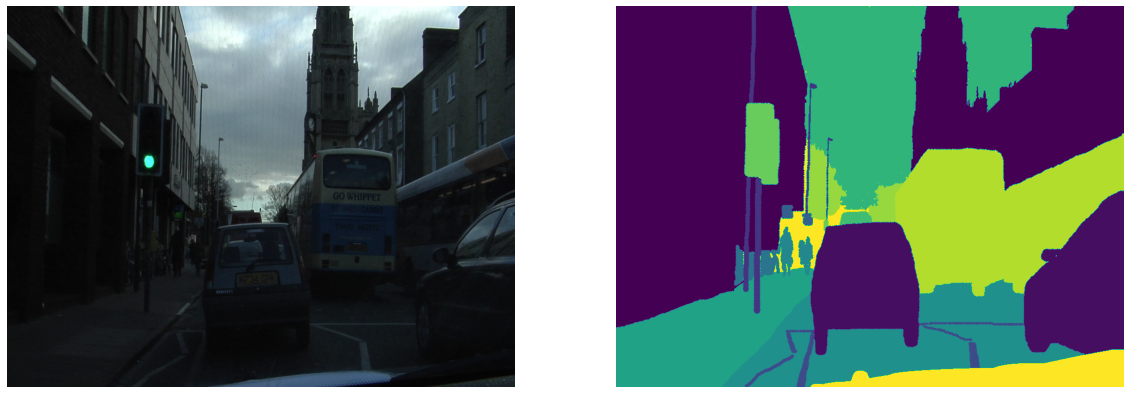

In [12]:
dp = pipes.Mapper(dp, PIL_open)

# show the tuple
show_images(next(iter(dp)), figsize=(20,10))

## `wandb.Image` and `wandb.Table` are our friends

In [172]:
import wandb
from tqdm.notebook import tqdm

In [179]:
dp_batched = dp.shuffle().batch(24)

def to_wandb_image(image, mask, class_labels=class_labels):
    "Cast PIL images to wandb.Image"
    wandb_image = wandb.Image(image)
    wandb_mask  = wandb.Image(image, masks={"predictions": 
                                            {"mask_data": np.array(mask),
                                             "class_labels": class_labels}})
    return wandb_image, wandb_mask

def create_table(samples):
    "Create a table with (Images, Masks)"
    table_data = []

    for img, mask in samples:
        table_data.append(to_wandb_image(img, mask))

    return wandb.Table(data=table_data, 
                       columns=["Images", "Segmentation_Masks"])

samples = next(iter(dp_batched))
table = create_table(samples)

In [180]:
import wandb

with wandb.init(project="torchdata", job_type="log_dataset"):
    wandb.log({"sample_batch":table})

In [26]:
@functional_datapipe("log_image")
class LogImageWandb(pipes.IterDataPipe):
    def __init__(self, source_dp: pipes.IterDataPipe, class_labels=None) -> None:
        super().__init__()
        self.source_dp = source_dp
        self.class_labels = class_labels
    
    def preprocess(self, image, mask):
        return (wandb.Image(image), 
                wandb.Image(image, masks={"predictions": 
                                          {"mask_data": np.array(mask),
                                           "class_labels": class_labels
                                          }
                                         })
               )
    
    def __iter__(self):
        for image, mask in self.source_dp:
            image, mask = self.preprocess(image, mask)
            wandb.log({"image": image, "mask":mask})
            yield image, mask

In [27]:
dp_img = LogImageWandb(dp, class_labels=class_labels)

In [28]:
# next(iter(dp_img))

In [30]:
dp_img = LogImageWandb(dp, class_labels=class_labels)

In [31]:
# dp_img = dp.log_image(class_labels=class_labels)

In [32]:
next(iter(dp_img))

(<wandb.sdk.data_types.Image at 0x7f461301ad30>,
 <wandb.sdk.data_types.Image at 0x7f455e467310>)

In [33]:
wandb.finish()

In [13]:
table_data = []
image_files = get_image_files(Path(artifact_dir)/"images")
labels = [str(class_labels[_lab]) for _lab in list(class_labels)]

print("Creating Table...")
for image_file in progress_bar(image_files):
    image = np.array(Image.open(image_file))
    mask_data = np.array(Image.open(label_func(image_file)))
    frequency_distribution = get_frequency_distribution(mask_data)
    table_data.append(
        [
            str(image_file.name),
            wandb.Image(image),
            wandb.Image(image, masks={
                "predictions": {
                    "mask_data": mask_data,
                    "class_labels": class_labels
                }
            })
        ] + [
            frequency_distribution[_lab] for _lab in labels
        ]
    )
wandb.log({
    "CamVid_Dataset": wandb.Table(
        data=table_data,
        columns=["File_Name", "Images", "Segmentation_Masks"] + labels
    )
})

NameError: name 'get_image_files' is not defined

## Zip to `DataPipes` together

> Putting two pipelines in parallel and merge them together with `Zipper` and map the `Image.open`

In [ ]:
images = pipes.FileLister([camvid_path/"images"], masks="*.png").map(Image.open)
labels = pipes.FileLister([camvid_path/"labels"], masks="*.png").map(Image.open)

> Note: The `FileLister` class by default sorts the returned files by name so they match

we merge both `DataPipes` using `Zipper`. We can also shuffle the results and batch!

In [ ]:
ds = pipes.Zipper(images, labels).shuffle().batch(3)

In [ ]:
batch = next(iter(ds))
for im, mk in batch:
    show_images([im, mk], figsize=(12,6))

## Directly reading a `.tar` file

> Reading the tar files as a data stream

In [ ]:
camvid_itertable = pipes.IterableWrapper(["camvid.tgz"])

In [ ]:
tgz = FileOpener(camvid_itertable, mode="b")
next(iter(tgz))

In [ ]:
files = tgz.load_from_tar()
next(iter(files))

In [ ]:
images = pipes.Filter(files, filter_fn=lambda tup: Path(tup[0]).parent.name == "images")
labels = pipes.Filter(files, filter_fn=lambda tup: Path(tup[0]).parent.name == "labels")

The `StreamWrapper` class returns a filename and a stream

In [ ]:
next(iter(images))

In [ ]:
images = pipes.RoutedDecoder(images, imagehandler("pil"))
labels = pipes.RoutedDecoder(labels, imagehandler("pill"))  # on mode pil-L

In [ ]:
next(iter(images))

but we do't get files in order, so we have to match them with `IterKeyZipper`, based on the filename

In [ ]:
def get_image_id(data):
    path, _ = data
    return Path(path).name.split(".")[0]

def get_label_id(data):
    path, _ = data
    return Path(path).name.split("_P")[0]

In [ ]:
dp = pipes.IterKeyZipper(images, 
                         labels, 
                         get_image_id, 
                         get_label_id).map(lambda tup: (tup[0][1], tup[1][1]))

this is extremely slow...

In [ ]:
next(iter(dp))

In [ ]:
show_images(next(iter(dp)))

> This article was originally published in the [Weights and Biases blog](http://wandb.me/torchdata)